# https://www.kaggle.com/wrecked22/simple-xgboost-with-feature-engineering-and-eda

# https://www.kaggle.com/rohan9889/xgb-lgbm-pipeline-featureengineering-house-price#Feature-Engineering-intuition

## 003をもとに、別の特徴量を作っていく。参考にしているのは上記のノートブック。

In [39]:
%matplotlib inline                      
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns                   # for beautiful plots
from scipy import stats                 # to calculate mode, skew and ANOVA, etc.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew #for some statistics

# importing alll the necessary packages to use the various classification algorithms
from sklearn.linear_model import LogisticRegression  # for Logistic Regression algorithm
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
from sklearn import metrics #for checking the model accuracy
from sklearn.metrics import mean_squared_error #for checking the model accuracy
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [40]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [41]:
train = import_data('../house price/train.csv')
test = import_data('../house price/test.csv')
Id = test.Id
target = train.SalePrice

Memory usage of dataframe is 0.90 MB
Memory usage after optimization is: 0.16 MB
Decreased by 81.7%
Memory usage of dataframe is 0.89 MB
Memory usage after optimization is: 0.16 MB
Decreased by 81.7%


In [42]:
alldata = import_data('../house price/alldata.csv')
alldata = alldata.iloc[:,2:]
alldata.head()

Memory usage of dataframe is 2.82 MB
Memory usage after optimization is: 0.47 MB
Decreased by 83.3%


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SimplKitchenQual,SimplHeatingQC,SimplBsmtFinType1,SimplBsmtFinType2,SimplBsmtCond,SimplBsmtQual,SimplExterCond,SimplExterQual,NeighborhoodBin,Neighborhood_Good
0,60,3,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,2,2,2,1,1,2,1,2,2,0.0
1,20,3,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,1,2,2,1,1,2,1,1,3,0.0
2,60,3,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,2,2,2,1,1,2,1,2,2,0.0
3,70,3,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,2,2,2,1,2,1,1,1,3,1.0
4,60,3,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,2,2,2,1,1,2,1,2,4,1.0


In [43]:
old_cols = train.columns.drop('Id')
old_cols

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [44]:
alldata2 = alldata[old_cols]

In [45]:
alldata['cond*qual'] = (alldata2['OverallCond'] * alldata2['OverallQual']) / 100.0
alldata['total_porch_area'] = alldata2['WoodDeckSF'] + alldata2['OpenPorchSF'] + alldata2['EnclosedPorch'] + alldata2['3SsnPorch'] + alldata2['ScreenPorch'] 
alldata['Totalsqrfootage'] = (alldata2['BsmtFinSF1'] + alldata2['BsmtFinSF2'] + alldata2['1stFlrSF'] + alldata2['2ndFlrSF'])
alldata['Total_Bathrooms'] = (alldata2['FullBath'] + (0.5 * alldata2['HalfBath']) + alldata2['BsmtFullBath'] + (0.5 * alldata2['BsmtHalfBath']))

In [46]:
alldata['GarageStatus'] = alldata2['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
alldata['BsmtStatus'] = alldata2['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
alldata['FirePlaceStatus'] = alldata2['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
alldata['PoolStatus'] = alldata2['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

In [47]:
alldata[alldata['GarageYrBlt'] == 2208]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,NeighborhoodBin,Neighborhood_Good,cond*qual,total_porch_area,Totalsqrfootage,Total_Bathrooms,GarageStatus,BsmtStatus,FirePlaceStatus,PoolStatus
2588,20,3,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,...,3,0.0,0.4,132,2147.0,2.0,1,1,1,0


In [48]:
alldata.loc[2558, 'GarageYrBlt'] = 2008

In [49]:
train_new = alldata[alldata['SalePrice'].notnull()]
test_new = alldata[alldata['SalePrice'].isnull()]

print("Train", train_new.shape)
print ('----------------')
print("Test", test_new.shape)

Train (1456, 133)
----------------
Test (1459, 133)


## モデリング（準備）

In [50]:
data = alldata

In [51]:
data['SalePrice'] = np.log(data['SalePrice'])
data['SalePrice']

0       12.247694
1       12.109011
2       12.317166
3       11.849398
4       12.429216
          ...    
2910          NaN
2911          NaN
2912          NaN
2913          NaN
2914          NaN
Name: SalePrice, Length: 2915, dtype: float32

In [52]:
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [53]:
train = data[:len(train_new)]
test = data[len(train_new):]

In [54]:
categorical_cols = list(data.select_dtypes(include=['category']).columns)
print(categorical_cols)

['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleCondition']


In [56]:
from sklearn import preprocessing
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, col_definition: dict):
    """
    col_definition: encode_col
    """
    n_train = len(train)
    train = data
    for f in col_definition['encode_col']:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

train, test = label_encoding(train, test, col_definition={'encode_col': categorical_cols})
print(train.shape, test.shape)

(1456, 133) (1459, 133)


In [57]:
X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test.drop('SalePrice', axis=1)

In [59]:
categorical_cols = ['Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition',
       'IsRegularLotShape', 'IsLandLevel',
       'IsLandSlopeGentle', 'IsElectricalSBrkr', 'IsGarageDetached',
       'IsPavedDrive', 'HasShed', 'Remodeled',
       'VeryNewHouse', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
       'HasOpenPorch', 'HasEnclosedPorch', 'Has3SsnPorch',
       'HasScreenPorch', 'HighSeason', 'NewerDwelling',
       'SaleCondition_PriceDown', 'BoughtOffPlan', 'BadHeating',
       'TimeSinceSold', 'SeasonSold', 'NeighborhoodBin']

## モデリング（lightgbm）

In [60]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'num_leaves': 24,
    'max_depth': 6,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.265255	valid_1's rmse: 0.266169
[20]	training's rmse: 0.18795	valid_1's rmse: 0.197711
[30]	training's rmse: 0.142042	valid_1's rmse: 0.158662
[40]	training's rmse: 0.115616	valid_1's rmse: 0.138242
[50]	training's rmse: 0.0996789	valid_1's rmse: 0.128503
[60]	training's rmse: 0.0901709	valid_1's rmse: 0.123096
[70]	training's rmse: 0.083897	valid_1's rmse: 0.120611
[80]	training's rmse: 0.0794663	valid_1's rmse: 0.119064
[90]	training's rmse: 0.0759809	valid_1's rmse: 0.11782
[100]	training's rmse: 0.0730978	valid_1's rmse: 0.116832
[110]	training's rmse: 0.070614	valid_1's rmse: 0.116448
[120]	training's rmse: 0.0680302	valid_1's rmse: 0.116204
[130]	training's rmse: 0.0657571	valid_1's rmse: 0.116194
Early stopping, best iteration is:
[124]	training's rmse: 0.0671559	valid_1's rmse: 0.115958
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.261692	valid_1's rmse: 0

In [61]:
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

CV: 0.12233257565628454


In [62]:
sub = pd.DataFrame({'Id': Id, 'SalePrice': 0})
y_sub = sum(y_preds) / len(y_preds)
y_sub = np.expm1(y_sub)
sub['SalePrice'] = y_sub
sub.to_csv('submission.csv', index=False)
# 12.936

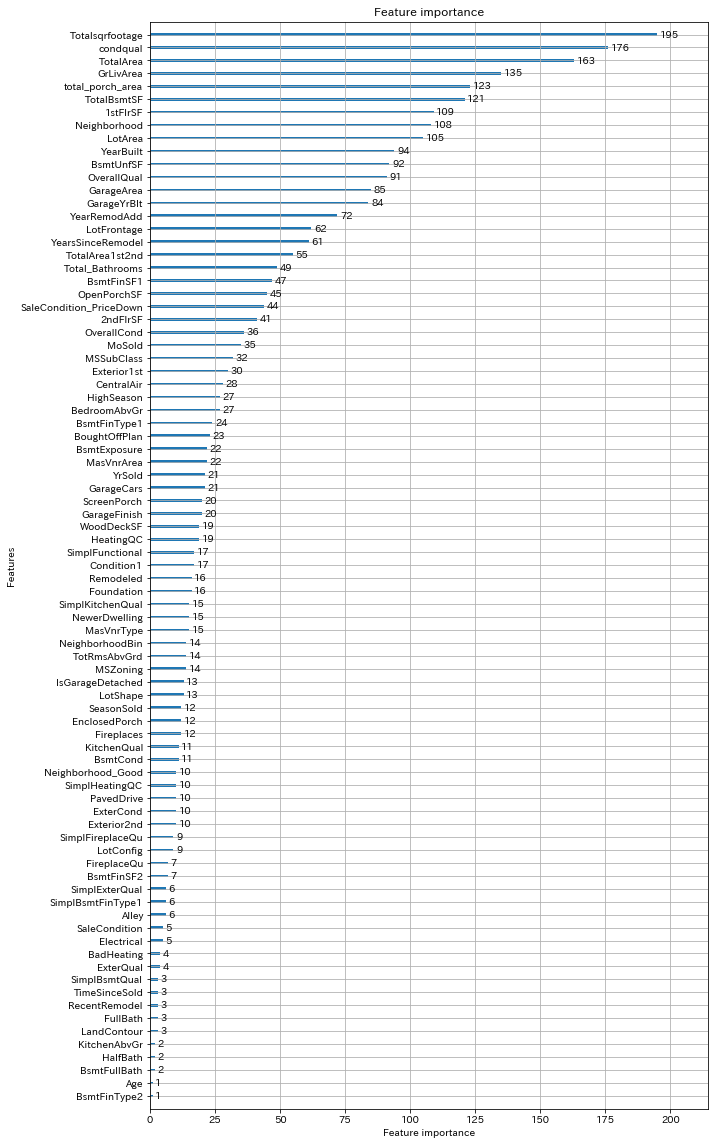

In [63]:
lgb.plot_importance(model, figsize=(10,20))

In [64]:
data.to_csv('004_data')